In [2]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import PercentFormatter
import datetime
import time
plt.style.use('default')
from alpha_vantage.timeseries import TimeSeries
import scipy.stats as st

In [5]:
plt.style.use('default')

#### Visual constants

In [6]:
minute_interval = 90
second_interval = minute_interval * 60

In [7]:
day_open = 60 * 60 * 9.5
trading_day_seconds = int((60 * 60 * 6.5))
trading_day_minutes = int(trading_day_seconds / 60)
times = [time.strftime('%I:%M', time.gmtime(i + day_open)) for i in range(trading_day_seconds + 1) 
             if i % second_interval == 0]
time_ids = [i for i in range(trading_day_seconds + 1) if i % second_interval == 0]
loc_of_random = ['']

#### Math constants

In [8]:
expected = (trading_day_seconds) ** 0.5  # expected travel from the start, wiki if unfamiliar
show_every = 60 
expected_volatility = 0.006  # the sd of the minute bar steps is set by a gamma about 0.6%
shape = 7
expected_open = 0.004

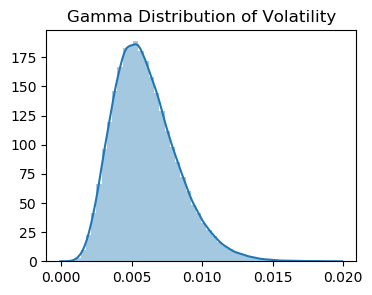

In [9]:
plt.figure(figsize=(4, 3))
sns.distplot(np.random.gamma(shape=shape, scale=expected_volatility / shape, size=100000))
plt.title('Gamma Distribution of Volatility',)
plt.show()

In [10]:
def get_random():
    volatility = np.random.gamma(shape=shape, scale=expected_volatility / shape)
    
    steps = np.random.randn(trading_day_seconds)  # changed + 1
    steps *= volatility
    
    prices = np.cumsum(steps) 
    prices /= expected # everything is divided by the expected distance away, set by the sqr root
                       # of the number of steps
    
    starting_price = expected_open * np.random.randn()  # normal with 0.4% standard deviation 
    prices += starting_price  # return
    
    prices = prices[::show_every]
    x = np.arange(trading_day_seconds)[::show_every]  # return  # changed + 1
    
    return x, prices

In [11]:
def plot_stock(axis, x, y):
    if y[-1] < 0:
        color = 'xkcd:red'
    else:
        color = 'xkcd:green'
    
    axis.grid(alpha=0.4)
    axis.plot([0], [0])
    axis.plot(x, y, color=color, alpha=0.9)
    
    axis.yaxis.set_major_formatter(PercentFormatter(1))
    axis.set_xlim(0, x[-1])

    lims = axis.get_ylim()
    axis.set_ylim(lims)
    axis.fill_between(x, np.full(len(x), lims[0]), y, alpha=0.1, color=color)
    axis.set_xticks(time_ids)
    axis.set_xticklabels(times)

In [12]:
def get_side(num):
    if num == 0:
        return 'left'
    elif num == 1:
        return 'right'

In [13]:
# reset after each game
prev_ns = list()

In [14]:
def side_by_side():
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(18, 6))
    fig.suptitle('One is a random walk, the other is an actual day in the stock market...',
                fontsize=20)
    # 13.5, 4.5
    # randomly put the random on the left or right, and the real in the other spot
    random_idx = np.random.randint(2)
    real_idx = 1 - random_idx

    random_x, random_y = get_random()
    plot_stock(axes[random_idx], random_x, random_y)
    
    real_x, real_y = get_real()
    plot_stock(axes[real_idx], real_x, real_y)
    
#     print(len(random_x))
    loc_of_random[0] = get_side(random_idx)
    
    plt.show()

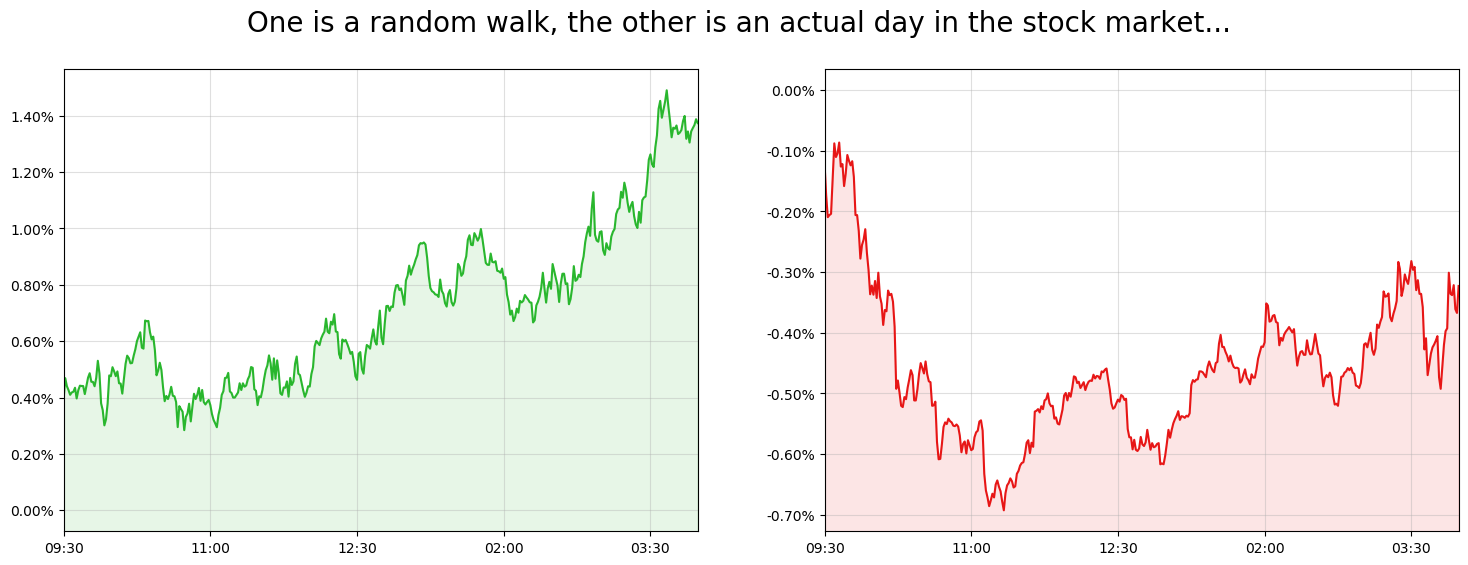

In [60]:
side_by_side()

In [61]:
loc_of_random

['left']

### Specific p-value calcuator

In [16]:
from scipy.special import comb

In [17]:
def p_value(n_correct, n_trials):
    # the number of selections to choose from is n_trials * 2 and
    # `n_trials` number of selections are made
    possible_combs = comb(n_trials * 2, n_trials)

    possible_as_or_greater_combs = 0
    for n in range(n_correct, n_trials + 1):
        # among the correct graphs, n are selected
        # and among the incorrect graphs, n_trials - n are selected
        possible_as_or_greater_combs += comb(n_trials, n) * comb(n_trials, n_trials - n)

    return possible_as_or_greater_combs / possible_combs

In [18]:
p_value(n_correct=4, n_trials=4)

0.014285714285714285

In [69]:
p = p_value(n_correct=2, n_trials=2)
print('The probability of performing this well or better by random guessing is: ', 
      "{0:.2%}".format(p))
if p < 0.05:
    print('At the 5% significance level, you CAN tell the difference. AMAZING!')
else:
    print('At the 5% significance level, you cannot tell the difference, SAD!')

The probability of performing this well or better by random guessing is:  16.67%
At the 5% significance level, you cannot tell the difference, SAD!


In [20]:
beta = 0.12
print('At the 5% significance level, you cannot tell the difference, SAD!')
print('The probability that this is a false negative, and you \
can actually tell the difference is {0:.1%}'.format(beta), end='.')

At the 5% significance level, you cannot tell the difference, SAD!
The probability that this is a false negative, and you can actually tell the difference is 12.0%.

In [21]:
print('At the 5% significance level, you CAN tell the difference. AMAZING!')
print('The probability that this is a true positive, and you \
can actually tell the difference is {0:.1%}'.format(1-beta), end='.')

At the 5% significance level, you CAN tell the difference. AMAZING!
The probability that this is a true positive, and you can actually tell the difference is 88.0%.

Calculate `beta` for each number of attempts beforehand?

We first need the standard deviation of the sample of the null population, which should just be the standard deviation of scores for random guessing `n` number of times, where `n` is the number of trials.

In [22]:
total_n_trials = 500
outcomes = list()
for n_trials in range(1, total_n_trials + 1):
    possible_combs = comb(n_trials * 2, n_trials)
        
    temp_outcomes = np.zeros(n_trials + 1)
    
    for n_correct in range(n_trials + 1):  # from getting 0 to all trials correct
        temp_outcomes[n_correct] = comb(n_trials, n_correct) * comb(n_trials, n_trials - n_correct)
        
    outcomes.append(temp_outcomes)

st_devs = np.zeros(total_n_trials)
avgs = np.zeros(total_n_trials)
for n_trials in range(1, total_n_trials + 1):
    avgs[n_trials - 1] = n_trials / 2
    
    summation = 0
    for n_correct in range(n_trials + 1):
        summation += outcomes[n_trials - 1][n_correct] * ((n_correct - avgs[n_trials - 1]) ** 2)
    
    st_devs[n_trials - 1] = (summation / sum(outcomes[n_trials - 1])) ** 0.5
    
sd_ratios = st_devs / avgs

Outcomes is just Pascal's triangle squared. (I added this fact to the wikipedia article on *Lady tasting tea*.)

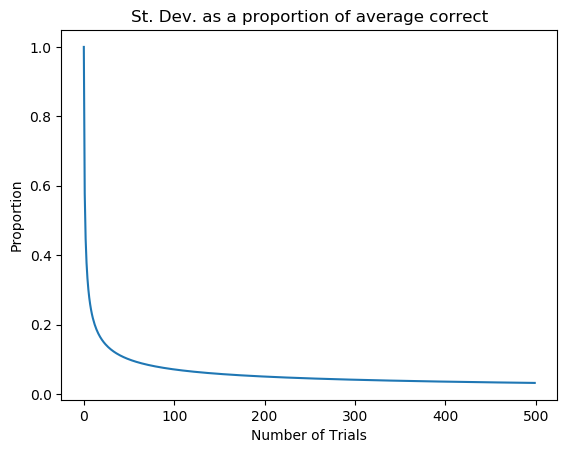

In [154]:
plt.plot(sd_ratios)
plt.title('St. Dev. as a proportion of average correct')
plt.ylabel('Proportion')
plt.xlabel('Number of Trials')
plt.show()

In [62]:
st.norm.ppf(.95)

1.6448536269514722

In [63]:
st.norm.cdf(1.64)

0.9494974165258963

In [66]:
x_criticals = (st.norm.ppf(.95) * st_devs) + avgs

In [79]:
avgs[:3]

array([0.5, 1. , 1.5])

In [75]:
st_devs[:3]

array([0.5       , 0.57735027, 0.67082039])

In [77]:
outcomes[:3]

[array([1., 1.]), array([1., 4., 1.]), array([1., 9., 9., 1.])]

In [73]:
x_criticals[:3]

array([1.32242681, 1.94965668, 2.60340136])

In [100]:
n_trials = 20

In [109]:
p_value(13, n_trials)

0.05641688774154798

In [105]:
x_criticals[n_trials - 1]

12.633873745633409

In [106]:
outcomes[n_trials - 1]

array([1.00000000e+00, 4.00000000e+02, 3.61000000e+04, 1.29960000e+06,
       2.34740250e+07, 2.40374016e+08, 1.50233760e+09, 6.00935040e+09,
       1.58684409e+10, 2.82105616e+10, 3.41347795e+10, 2.82105616e+10,
       1.58684409e+10, 6.00935040e+09, 1.50233760e+09, 2.40374016e+08,
       2.34740250e+07, 1.29960000e+06, 3.61000000e+04, 4.00000000e+02,
       1.00000000e+00])

In [130]:
ps = list()
psvs = list()
for n_trials in range(1, 100):
    cont = True
    for n_correct in range(n_trials + 1):  # from getting 0 to all trials correct
        if cont:
            if p_value(n_correct, n_trials) <= 0.05:
                cont = False
                ps.append(n_correct)
                psvs.append(p_value(n_correct, n_trials))
    if cont:
        ps.append(n_trials)
        psvs.append(float('nan'))
    

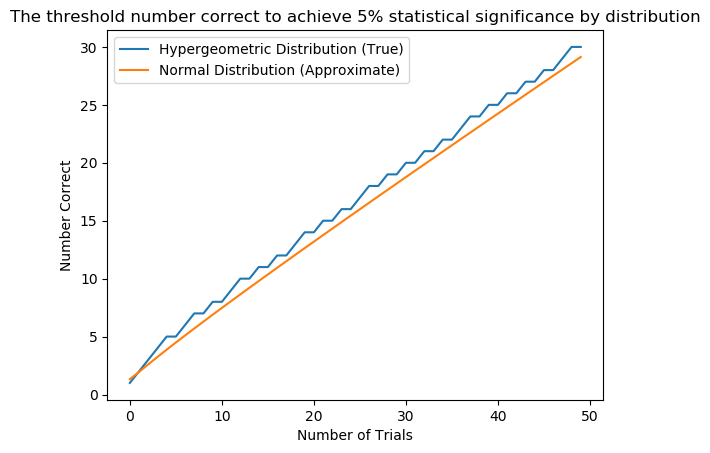

In [155]:
upto = 50
plt.plot(ps[:upto], label='Hypergeometric Distribution (True)')
plt.plot(x_criticals[:upto], label='Normal Distribution (Approximate)')
plt.xlabel('Number of Trials')
plt.ylabel('Number Correct')
plt.title('The threshold number correct to achieve 5% statistical significance by distribution')
plt.legend()
plt.show()

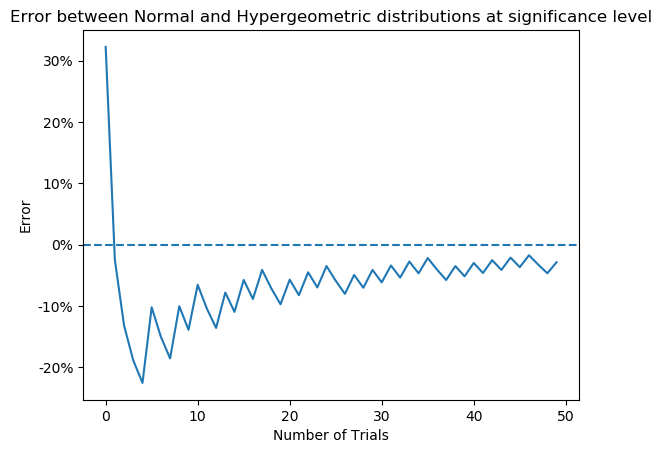

In [156]:
plt.plot((x_criticals[:upto] / ps[:upto]) - 1)
plt.axhline(y=0, linestyle='--')
plt.title('Error between Normal and Hypergeometric distributions at significance level')
plt.ylabel('Error')
plt.xlabel('Number of Trials')
plt.gca().yaxis.set_major_formatter(PercentFormatter(1))
plt.show()

Clearly the normal distribution becomes a better approximation as the number of trials increases

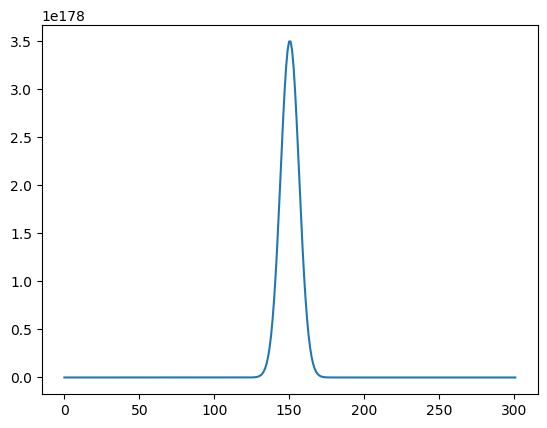

In [128]:
Mplt.plot(outcomes[300])

### Read from stock data

In [28]:
import pandas as pd

read_file = pd.read_csv (r'../SPX-SAMPLE/SPX_sample.txt')
read_file.to_csv (r'../data/fr_sample.csv', index=None)

In [29]:
dfs = pd.read_csv('../data/fr_sample.csv', header=None)

In [30]:
dfs.columns = ['datetime', 'open', 'high', 'low', 'close']

In [31]:
temp = pd.DataFrame(dfs.datetime.str.split().tolist())

In [32]:
dfs = pd.concat([temp, dfs.iloc[:,1:]], axis=1)

In [33]:
dfs.columns = ['date', 'time', 'open', 'high', 'low', 'close']

In [34]:
dates = dfs.date.unique()

In [35]:
dfs.iloc[0,5] = '1443.44'

In [36]:
dfs.close = dfs.close.astype('float')

In [37]:
dfs.sample(10)

,date,time,open,high,low,close
5942,2013.01.23,14:02:00,1494.42,1494.62,1494.42,1494.54
923,2013.01.04,11:23:00,1462.09,1462.09,1461.95,1461.97
3399,2013.01.14,12:09:00,1468.95,1468.95,1468.83,1468.83
79,2013.01.02,10:49:00,1452.18,1452.31,1451.87,1451.87
5558,2013.01.22,14:23:00,1489.92,1489.92,1489.86,1489.86
2420,2013.01.09,16:05:00,1461.02,1461.02,1461.02,1461.02
2464,2013.01.10,10:04:00,1467.31,1467.64,1467.3,1467.61
736,2013.01.03,15:01:00,1460.30,1460.51,1460.18,1460.49
3765,2013.01.15,11:30:00,1467.34,1467.78,1467.34,1467.77
2901,2013.01.11,10:36:00,1467.72,1467.80,1467.69,1467.80


In [38]:
dfs = dfs.loc[~dfs.time.isin(['16:00:00', '16:01:00', '16:02:00', '16:03:00', '16:04:00',
       '16:05:00', '16:06:00', '16:07:00', '16:08:00', '16:09:00',
       '16:10:00', '16:11:00', '16:12:00', '16:13:00', '16:14:00'])]

In [39]:
N_raw = len(dates)

In [40]:
for i in range(N_raw):
    print(dates[i])

2013.01.02
2013.01.03
2013.01.04
2013.01.07
2013.01.08
2013.01.09
2013.01.10
2013.01.11
2013.01.14
2013.01.15
2013.01.16
2013.01.17
2013.01.18
2013.01.22
2013.01.23


In [41]:
for i in range(N_raw):
    assert dfs.loc[dfs.date == dates[i]].close.shape == (390,)

In [42]:
N = N_raw - 1

In [43]:
data = np.zeros((N, trading_day_minutes))
prev_close = np.zeros(N)
trading_dates = list()
for i in range(1, N_raw):
    data[i-1,] = dfs.loc[dfs.date == dates[i]].close
    prev_close[i-1] = dfs.loc[dfs.date == dates[i-1]].close.tolist()[-1]
    trading_dates.append(dates[i])

for i in range(N):
    data[i] /= prev_close[i]
    data[i] -= 1
#     data[i] *= 100

In [44]:
trading_dates = np.array(trading_dates)

In [45]:
s = '2013.12.10'
my_date = datetime.datetime.strptime(s, '%Y.%m.%d')
print(my_date.strftime("%A, %B %-d, %Y")) # 23 Dec, 2011

Tuesday, December 10, 2013


### Save to disk

In [46]:
# np.save('data', data)

In [47]:
# np.save('trading_dates', trading_dates)

In [48]:
# np.load('data.npy')

In [49]:
def get_real():
    x = np.arange(trading_day_seconds, step=60)
    
    while True:  # set the date_n
        date_n = np.random.randint(N)
        if len(prev_ns) >= N:
            break
        if date_n not in prev_ns:
            break
    prev_ns.append(date_n)
    
    y = data[date_n]
    return x, y

385    1459.92
386    1459.25
387    1459.93
388    1460.31
389    1461.36
Name: close, dtype: float64


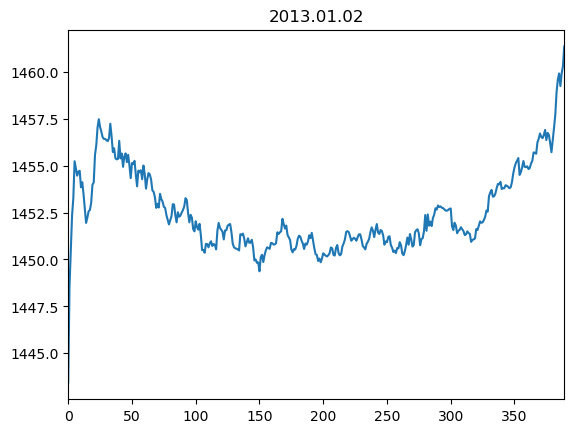

790    1457.23
791    1457.24
792    1457.05
793    1457.03
794    1459.07
Name: close, dtype: float64


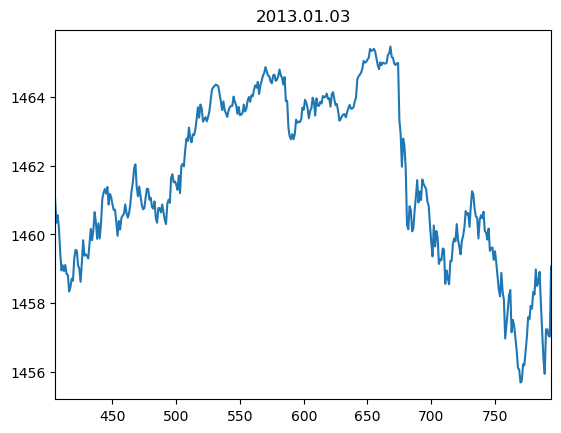

1195    1467.43
1196    1467.21
1197    1466.57
1198    1465.98
1199    1466.10
Name: close, dtype: float64


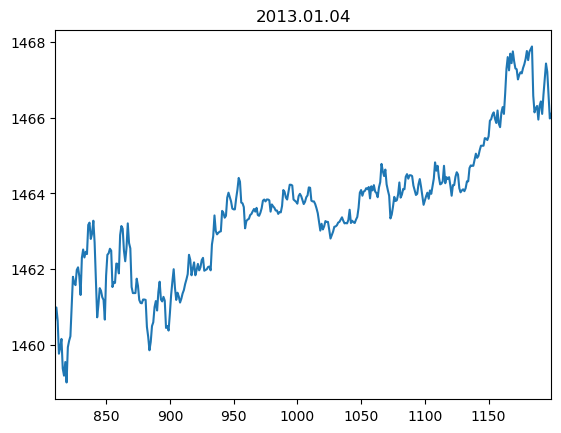

1600    1461.79
1601    1461.73
1602    1461.82
1603    1461.51
1604    1461.77
Name: close, dtype: float64


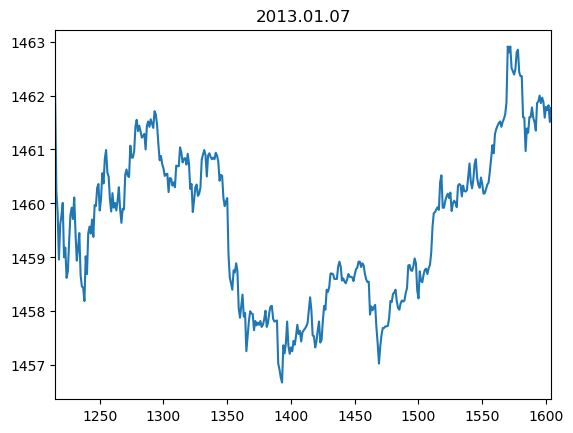

2005    1456.83
2006    1457.07
2007    1456.49
2008    1456.40
2009    1457.05
Name: close, dtype: float64


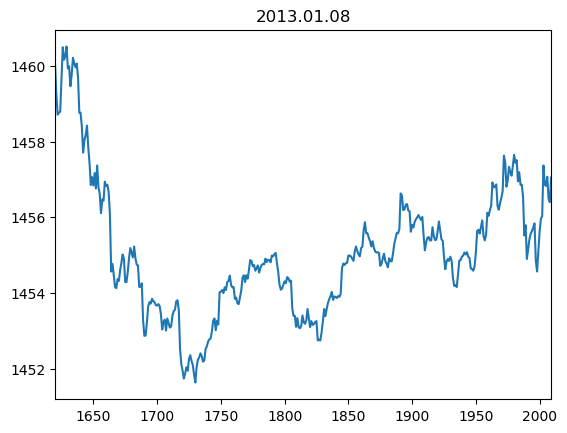

2410    1459.96
2411    1460.12
2412    1460.15
2413    1460.42
2414    1461.04
Name: close, dtype: float64


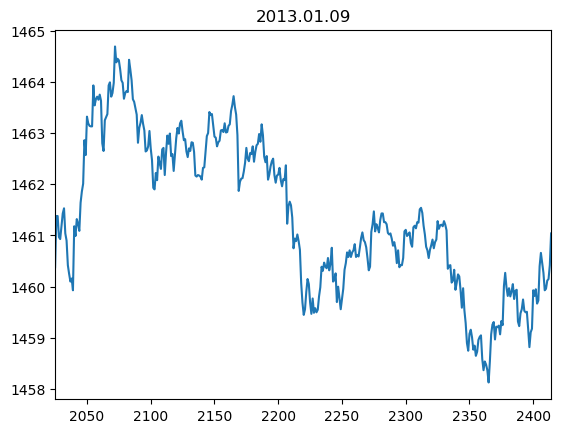

2815    1471.30
2816    1471.25
2817    1471.16
2818    1471.08
2819    1471.99
Name: close, dtype: float64


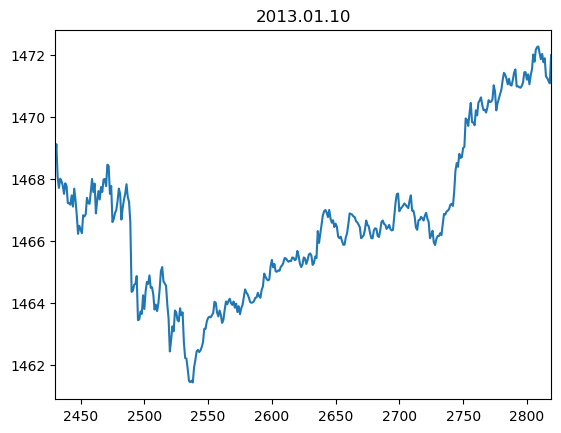

3220    1471.75
3221    1471.42
3222    1471.43
3223    1471.37
3224    1471.71
Name: close, dtype: float64


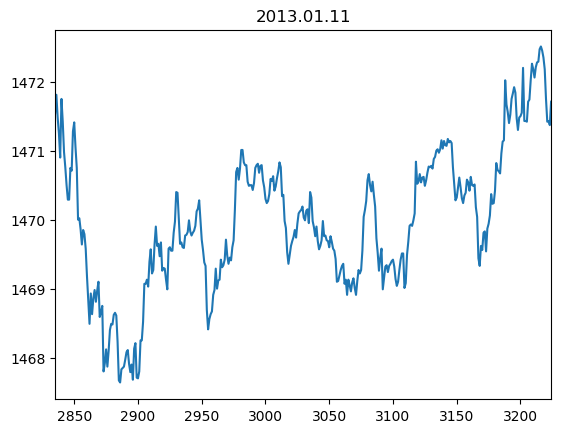

3625    1468.86
3626    1469.13
3627    1469.39
3628    1469.26
3629    1470.79
Name: close, dtype: float64


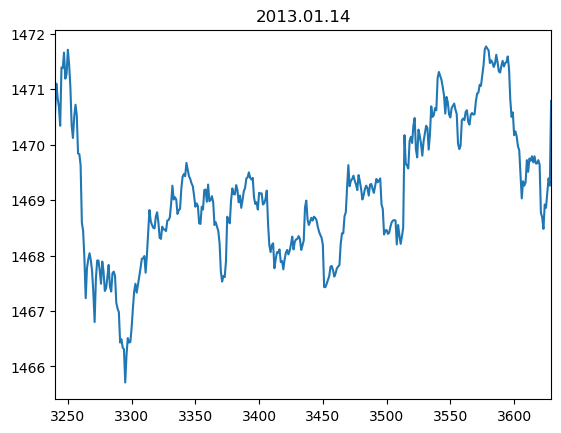

4030    1472.23
4031    1472.06
4032    1472.24
4033    1472.48
4034    1472.31
Name: close, dtype: float64


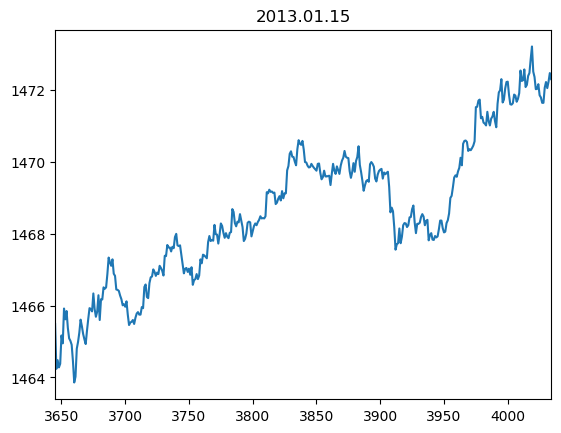

4435    1472.07
4436    1471.99
4437    1472.11
4438    1471.85
4439    1472.59
Name: close, dtype: float64


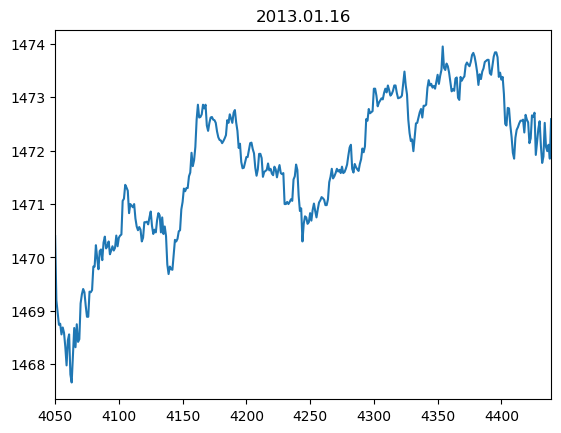

4840    1481.42
4841    1482.05
4842    1482.33
4843    1482.39
4844    1481.29
Name: close, dtype: float64


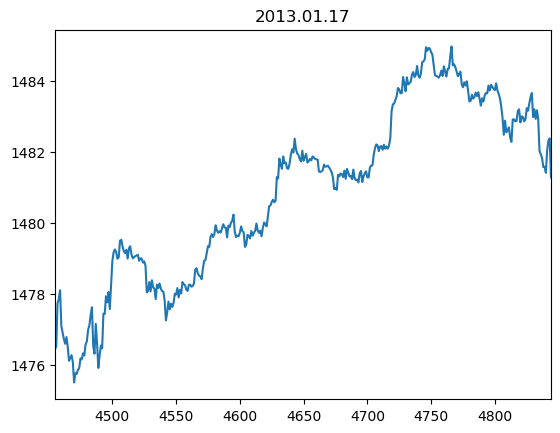

5245    1484.86
5246    1485.17
5247    1485.34
5248    1485.04
5249    1485.81
Name: close, dtype: float64


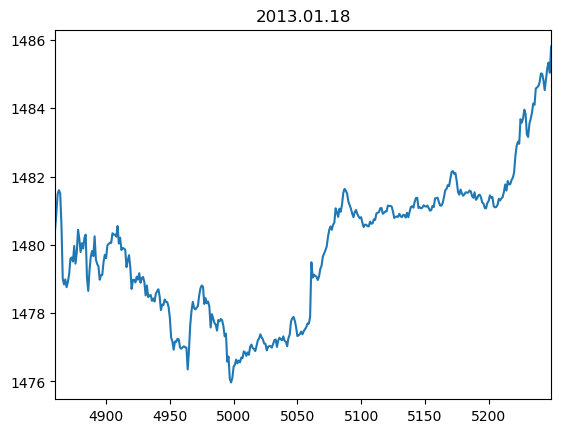

5650    1491.68
5651    1491.95
5652    1491.64
5653    1491.72
5654    1491.85
Name: close, dtype: float64


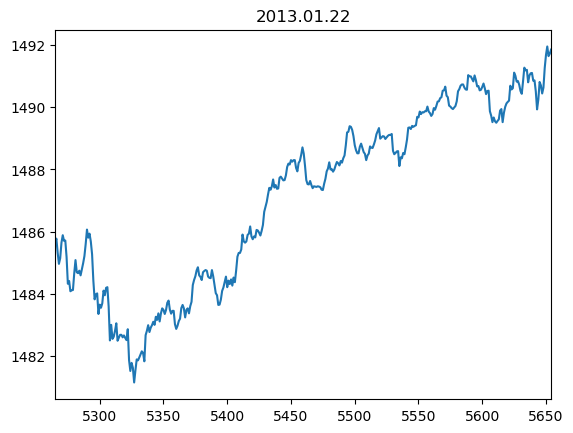

6055    1494.31
6056    1494.40
6057    1494.63
6058    1494.52
6059    1494.70
Name: close, dtype: float64


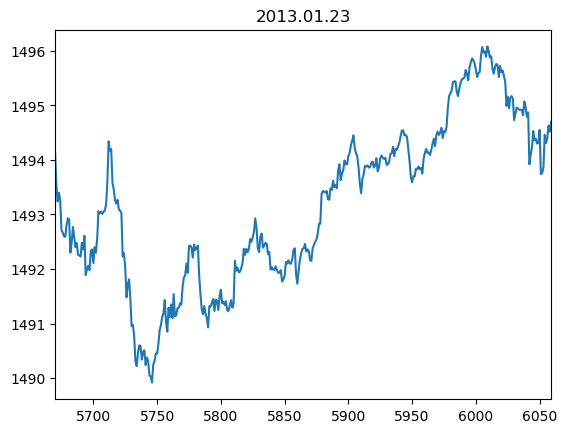

In [154]:
for i in range(len(dates)):
    date = dates[i]
    print(dfs.loc[dfs.date == date].close.tail())
    dfs.loc[dfs.date == date][:].close.plot()
    plt.title(date)
    plt.show()

In [156]:
dfs.date.unique()

array(['2013.01.02', '2013.01.03', '2013.01.04', '2013.01.07',
       '2013.01.08', '2013.01.09', '2013.01.10', '2013.01.11',
       '2013.01.14', '2013.01.15', '2013.01.16', '2013.01.17',
       '2013.01.18', '2013.01.22', '2013.01.23'], dtype=object)

In [ ]:
# for i in range(1):
#     steps = np.random.randn(seconds + 1)
#     expected_volatility = 0.006  # the sd of the minute bar steps is set by a gamma about 0.6%
#     shape = 7
#     volatility = np.random.gamma(shape=shape, scale=expected_volatility / shape)
#     steps *= volatility
    
#     prices = np.cumsum(steps) 
#     prices /= expected # everything is divided by the expected distance away, set by the sqr root
#                        # of the number of steps
    
#     starting_price = 0.004 * np.random.randn()  # normal with 0.4% standard deviation 
#     prices += starting_price

#     if prices[-1] < 0:
#         color = 'xkcd:red'
#     else:
#         color = 'xkcd:green'

#     show_every = 60  # show every certain number of seconds
    
#     plt.figure(figsize=(12, 6))
#     plt.plot([0], [0])
#     plt.plot(np.arange(seconds + 1)[::show_every], prices[::show_every], color=color, alpha=0.9)
#     plt.xticks(time_ids, times)

#     plt.gca().yaxis.set_major_formatter(PercentFormatter(1))

#     plt.grid(alpha=0.4)
#     plt.xlim(0, seconds + 1)
#     lims = plt.ylim()
#     plt.ylim(lims)
#     plt.fill_between(np.arange(seconds + 1)[::show_every], 
#                      np.full(seconds + 1, lims[0])[::show_every], 
#                      prices[::show_every], 
#                     alpha=0.1, color=color)
    
# #     print(100 * volatility)
#     plt.show()
# #     print('\n\n\n')

### Alpha Vantage

In [14]:
# Your key here
key = '0B2RGQVL7RX2DXAA'
ts = TimeSeries(key)

In [15]:
aapl, meta = ts.get_daily(symbol='AAPL')

In [19]:
print(aapl['2019-11-29'])

{'1. open': '266.6000', '2. high': '268.0000', '3. low': '265.9000', '4. close': '267.2500', '5. volume': '11654363'}


In [ ]:
from alpha_vantage.timeseries import TimeSeries
from alpha_vantage.techindicators import TechIndicators
from matplotlib.pyplot import figure
import matplotlib.pyplot as plt


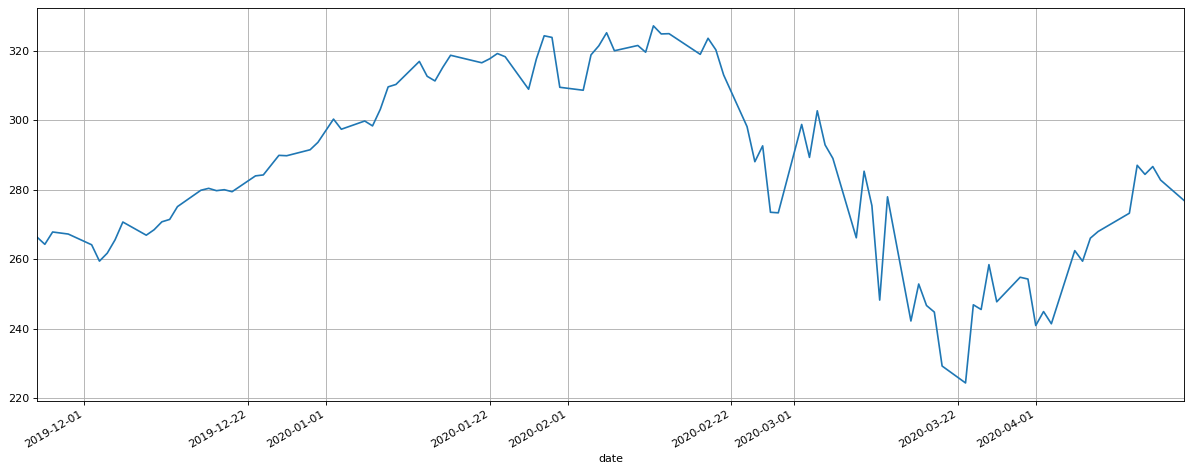

In [23]:
# Chose your output format, or default to JSON (python dict)
ts = TimeSeries(key, output_format='pandas')
ti = TechIndicators(key)

# Get the data, returns a tuple
# aapl_data is a pandas dataframe, aapl_meta_data is a dict
aapl_data, aapl_meta_data = ts.get_daily(symbol='AAPL')
# aapl_sma is a dict, aapl_meta_sma also a dict
aapl_sma, aapl_meta_sma = ti.get_sma(symbol='AAPL')


# Visualization
figure(num=None, figsize=(15, 6), dpi=80, facecolor='w', edgecolor='k')
aapl_data['4. close'].plot()
plt.tight_layout()
plt.grid()
plt.show()

In [35]:
ts = TimeSeries(key=key, output_format='pandas')
data, meta_data = ts.get_intraday(symbol='MSFT',interval='1min', outputsize='full')
print(data.head(2))

                     1. open  2. high  3. low  4. close  5. volume
date                                                              
2020-04-20 16:00:00   175.00   175.00  175.00    175.00   545027.0
2020-04-20 15:59:00   175.44   175.47  175.25    175.31   263956.0


In [36]:
data

,1. open,2. high,3. low,4. close,5. volume
date,,,,,
2020-04-20 16:00:00,175.000,175.000,175.0000,175.0000,545027.0
2020-04-20 15:59:00,175.440,175.470,175.2500,175.3100,263956.0
2020-04-20 15:58:00,175.420,175.540,175.3600,175.4400,193622.0
2020-04-20 15:57:00,175.440,175.590,175.3627,175.4300,193743.0
2020-04-20 15:56:00,175.290,175.490,175.2000,175.4200,213976.0
...,...,...,...,...,...
2020-04-15 09:35:00,171.350,171.350,170.9758,170.9758,196950.0
2020-04-15 09:34:00,171.300,171.300,171.3000,171.3000,164388.0
2020-04-15 09:33:00,170.780,171.130,170.6000,170.9450,165145.0


In [39]:
ts1 = TimeSeries(key=key, output_format='pandas')
data1, meta_data1 = ts.get_intraday(symbol='^GSPC',interval='5min', outputsize='full')
print(data.head(2))

                     1. open  2. high  3. low  4. close  5. volume
date                                                              
2020-04-20 16:00:00   175.00   175.00  175.00    175.00   545027.0
2020-04-20 15:59:00   175.44   175.47  175.25    175.31   263956.0


In [40]:
data1

,1. open,2. high,3. low,4. close,5. volume
date,,,,,
2020-04-21 13:40:00,2750.4800,2756.1599,2748.6799,2756.0400,19419810.0
2020-04-21 13:35:00,2750.6899,2750.9199,2747.7000,2750.4900,17977681.0
2020-04-21 13:30:00,2749.2300,2750.9299,2747.4399,2750.6399,17175518.0
2020-04-21 13:25:00,2744.1799,2751.6001,2744.0601,2749.6499,20065388.0
2020-04-21 13:20:00,2740.9900,2745.3999,2740.4199,2744.1499,17238969.0
...,...,...,...,...,...
2020-03-31 09:55:00,2598.3401,2601.9600,2592.7600,2595.3301,42380856.0
2020-03-31 09:50:00,2609.1001,2609.1799,2597.8401,2598.4299,45294794.0
2020-03-31 09:45:00,2607.4800,2616.8999,2607.4800,2609.4900,47545650.0
